# Use of tanh funtion as the activation function for hidden layer
# Use of He initialization for initializing weight and biases

In [1]:
import math
import struct as st
import numpy as np
import matplotlib.pyplot as plt

In [2]:
 # Initialize the Parameters(He initialization)
def initialize_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*np.sqrt(2/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters    

In [3]:
#Activation Funtion
def sigmoid(Z):
    A=1/(1+np.exp(-Z))
    return A

def tanh(Z):               # Use of tanh function
    A=np.tanh(Z)
    return A

In [4]:
#Calculation of Z = W*A_previouse + B
def linear_forward(A,W,b):
    Z=np.dot(W,A)+b
    return Z

In [5]:
# Calculation the of the activation Funtion. 
#        A = Sigmoid(Z) **Need to Update**
def linear_activation_forward(A_prev, W, b, activation_type): 
    
    if activation_type == "Sigmoid":            #Use of activation funtion in hidden layer is Sigmoid funtion
        Z=linear_forward(A_prev,W,b)
        A=sigmoid(Z)
    elif activation_type == "tanh":
        Z=linear_forward(A_prev,W,b)
        A=tanh(Z)
                   
    return A,Z  

In [6]:
#Compute Cost of the overall model.
#       Cost = Summation(Loss)/(Number of input data), where Loss= - Y*ln(Activation) - (1-Y)*ln(1 - Activation)
def compute_cost(AL,Y):
    data_length = Y.shape[1]
    cost =(-1/data_length) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    cost = np.squeeze(cost)
    assert(cost.shape == ())  
    return cost

In [7]:
# Linear_backward
def linear_backward(dZ, A):
    data_length = A.shape[1]
    dW = (1/data_length)*np.dot(dZ,A.T)
    db = (1/data_length)*np.sum(dZ, axis=1, keepdims=True)
    return dW,db

In [8]:
# Linear_activation_backward
def linear_activation_backward(A, cache, Layer):
    if Layer == "Output Layer":
        Y, AL = cache
        dZ2 = A - Y
        dW, db = linear_backward(dZ2, AL)
        return dZ2, dW, db
    elif Layer == "Hidden Layer":
        X, W2, dZ2 = cache
        dZ1 = np.dot(W2.T,dZ2)*(1-pow(A,2))
        dW, db = linear_backward(dZ1, X)
        return dZ1,dW, db

In [9]:
# Updates the parameters according to the obtained gradient values
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters)//2           # number of layers in the neural network
    
    for l in range(L):                  # Update rule for each parameter. Use a for loop.
        parameters["W" + str(l+1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]    
    return parameters

In [10]:
# Main body of the Nueral Net Model which contains the procedural instructions to the execution of Nueral net model
def L_layer_network(X,Y,learningrate,layer_dims,num_iterations,print_cost):
    costs=[]
    
    #Initailise and fetch the weights through dictionary
    parameters = initialize_parameters(layer_dims)
    L = len(parameters) // 2                           # number of layers in the neural network
    activation = {}
    linearsum = {}
    
    for i in range(0, num_iterations):
        A = X
        # Forward propagation
        for l in range(1, L):
            A_prev = A
            activation['A'+str(l)], linearsum['Z'+str(l)] = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b' + str(l)], "tanh")   #Calculation of activaion output of hidden layer
            A = activation['A'+str(l)]
        
        activation['A'+str(L)], linearsum['Z'+str(L)] = linear_activation_forward(A, parameters['W'+str(L)], parameters['b' + str(L)], "Sigmoid")        #Calculation of activation output of output layer
    
        # Compute cost
        cost = compute_cost(activation['A'+str(L)], Y)
        costs.append(cost)
        
         # Stores the gradient values in the dictionary grads
        grads = {}
        data_length = Y.shape[1]
        
        # Backward propagation
        activation['A'+str(0)] = X
        cache = (Y, activation['A'+str(L-1)])
        linearsum['dZ'+str(L)] ,grads['dW'+str(L)], grads['db'+str(L)] = linear_activation_backward(activation['A'+str(L)], cache, "Output Layer")
        
        for l in reversed(range(1,L)):
            cache = (activation['A'+str(l-1)], parameters['W'+str(l+1)], linearsum['dZ'+str(l+1)])
            linearsum['dZ'+str(l)], grads['dW'+str(l)], grads['db'+str(l)] = linear_activation_backward(activation['A'+str(l)], cache, "Hidden Layer")
        
    
        # Update the parameters
        parameters =  update_parameters(parameters, grads, learningrate)
        
        #Vary the learning rate
        if(cost > 0.37):
            learningrate = learningrate
        elif(cost<0.37 and cost>0.2):
            learningrate = 0.5
        elif(cost<0.25 and cost>0.1):
            learningrate = 0.3
            
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    
    #Plot the cost funtion curve
    plt.plot(costs)
    plt.ylabel("Cost")
    plt.xlabel("iterations")
    plt.show()
    return parameters,activation,linearsum

In [11]:
# Input Data(MNIST)

filename = {'images' : 'E:/Handwritten digit recognisation/dataset/train-images-idx3-ubyte' ,'labels' : 'E:/Handwritten digit recognisation/dataset/train-labels-idx1-ubyte'}
train_imagesfile = open(filename['images'],'rb')

MagicNumber = st.unpack('>I',train_imagesfile.read(4))[0]
nImg = st.unpack('>I',train_imagesfile.read(4))[0] #num of images
nR = st.unpack('>I',train_imagesfile.read(4))[0] #num of rows
nC = st.unpack('>I',train_imagesfile.read(4))[0] #num of column
print("Magic Number : ", MagicNumber)
print("num of images : ", nImg)
print("num of rows : ", nR)
print("num of column : ", nC)

images_array = np.zeros((nImg,nR,nC))

nBytesTotal = nImg*nR*nC*1 #since each pixel data is 1 byte
images_array = np.asarray(st.unpack('>'+'B'*nBytesTotal,train_imagesfile.read(nBytesTotal))).reshape((nImg,nR,nC))

X = (1/255)*images_array.reshape(nImg,nR*nC)

print("Size images_array :",X.shape)

Magic Number :  2051
num of images :  60000
num of rows :  28
num of column :  28
Size images_array : (60000, 784)


Magic Number :  2049
num of images :  60000
Size images_array :  60000
Cost after iteration 0: 6.675664197906412
Cost after iteration 100: 2.69824800624126
Cost after iteration 200: 2.365772294935183
Cost after iteration 300: 2.046430436756372
Cost after iteration 400: 1.8058399390201167
Cost after iteration 500: 1.5053635088830164
Cost after iteration 600: 1.3806041724318106
Cost after iteration 700: 1.3070145697462803
Cost after iteration 800: 1.2584231538673174
Cost after iteration 900: 1.2887226581708386
Cost after iteration 1000: 1.1040502097478702
Cost after iteration 1100: 1.1273174767728733
Cost after iteration 1200: 1.0667147338066367
Cost after iteration 1300: 1.026304378295437
Cost after iteration 1400: 0.9742741833682639
Cost after iteration 1500: 0.9428566825786575
Cost after iteration 1600: 0.9301229398862234
Cost after iteration 1700: 0.8578879234514108
Cost after iteration 1800: 0.8237356856118793
Cost after iteration 1900: 0.7940267385226057
Cost after iteration 2000: 

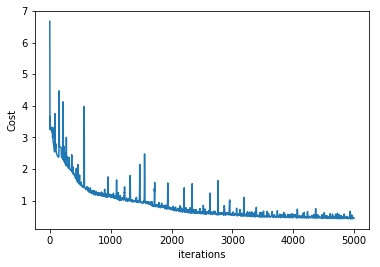

In [12]:
layer_dims = [np.squeeze(np.shape(X[0])),20,10,10]
learningrate = 1
print_cost=True

#Label Data(MNIST)
train_labelfile = open(filename['labels'],'rb')
MagicNumber = st.unpack('>I',train_labelfile.read(4))[0]
nlabel = st.unpack('>I',train_labelfile.read(4))[0] #num of labels
print("Magic Number : ", MagicNumber)
print("num of images : ", nlabel)
label_array = np.zeros((nlabel))

nBytesTotal = nlabel*1 #since each pixel data is 1 byte
label_array = np.asarray(st.unpack('>'+'B'*nBytesTotal,train_labelfile.read(nBytesTotal))).reshape((nlabel))

print("Size images_array : ",len(label_array))

Y=np.zeros((len(label_array),10))
for i in range (0,len(label_array)):
    for j in range (0,10):
        if label_array[i]==j:
            Y[i][j] = 1
        else:
            Y[i][j] = 0

parameters,activation,linearsum = L_layer_network(X.T, Y.T, learningrate, layer_dims, 5000, print_cost)

In [13]:
# Decodes the output that the trained model predicts on the testing set
def Output(A2):
    key = A2[0][0]
    p = 0
    for i in range (0,10):
        if A2[i][0]>=key:
                p = i
                key = A2[i][0]
    return p

In [14]:
# Calculates the accuracy the trained model is able to achieve
def accuracy_predictor(out, label_array):
    fav = 0
    for i in range(0,51):
        if(out[i]==label_array[i]):
            fav = fav + 1
    accuracy = fav/51*100
    return accuracy

In [15]:
def modeltest(X,parameters,activation,linearsum,out):
    L = len(parameters) // 2 
    A = X
    for l in range(1, L):
            A_prev = A
            activation['A'+str(l)], linearsum['Z'+str(l)] = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b' + str(l)], "tanh")   #Calculation of activaion output of hidden layer
            A = activation['A'+str(l)]
        
    activation['A'+str(L)], linearsum['Z'+str(L)] = linear_activation_forward(A, parameters['W'+str(L)], parameters['b' + str(L)], "Sigmoid")        #Calculation of activation output of output layer
    
    A = Output(activation['A'+str(L)])
    out.append(A)
    return out

In [16]:
Train_X=np.zeros(shape=(784,1))
out = []
filename = {'images' : 'E:/Handwritten digit recognisation/dataset/t10k-images-idx3-ubyte' ,'labels' : 'E:/Handwritten digit recognisation/dataset/t10k-labels-idx1-ubyte'}
Test_imagesfile = open(filename['images'],'rb')

MagicNumber = st.unpack('>I',Test_imagesfile.read(4))[0]
nImg = st.unpack('>I',Test_imagesfile.read(4))[0] #num of images
nR = st.unpack('>I',Test_imagesfile.read(4))[0] #num of rows
nC = st.unpack('>I',Test_imagesfile.read(4))[0] #num of column
print("Magic Number : ", MagicNumber)
print("num of images : ", nImg)
print("num of rows : ", nR)
print("num of column : ", nC)

Tex = np.zeros((nImg,nR,nC))

nBytesTotal = nImg*nR*nC*1 #since each pixel data is 1 byte
Tex = (1/255)*np.asarray(st.unpack('>'+'B'*nBytesTotal,Test_imagesfile.read(nBytesTotal))).reshape((nImg,nR*nC))

print("Size images_array : ",Tex.shape)

Test_labelfile = open(filename['labels'],'rb')

MagicNumber = st.unpack('>I',Test_labelfile.read(4))[0]
nlabel = st.unpack('>I',Test_labelfile.read(4))[0] #num of labels
print("Magic Number : ", MagicNumber)
print("num of images : ", nlabel)

label_arrayT = np.zeros((nlabel))

nBytesTotal = nlabel*1 #since each pixel data is 1 byte
label_arrayT= np.asarray(st.unpack('>'+'B'*nBytesTotal,Test_labelfile.read(nBytesTotal))).reshape((nlabel))


print("Size images_array : ",len(label_arrayT))

Magic Number :  2051
num of images :  10000
num of rows :  28
num of column :  28
Size images_array :  (10000, 784)
Magic Number :  2049
num of images :  10000
Size images_array :  10000


In [17]:
for j in range(0,len(label_arrayT)):
    for i in range(0,784):
        Train_X[i][0] = Tex[j][i]
    out = modeltest(Train_X, parameters,activation,linearsum, out)
    
accuracy = accuracy_predictor(out,label_arrayT)    
print("A :",out, end=" ")
print("\n\naccuracy = ", accuracy, end="%")
print("\nout",len(out))

A : [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 3, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 3, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 3, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 5, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 1, 3, 9, 7, 4, 4, 4, 9, 7, 5, 4, 7, 6, 4, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 4, 9, 8, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 8, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 8, 9, 3, 9, 0, 3, 5, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 9, 7, 9, 2, 2, 4, 1, 5, 8, 8, 7, 2, 5, 0, 6, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 0, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 3, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 7, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 9, 3, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2,